<a href="https://colab.research.google.com/github/IT21305900/CTSE_RAG/blob/main/CTSE_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langchain-openai langchain-community langchain-experimental langgraph
!pip install chromadb pypdf tiktoken faiss-cpu
!pip install matplotlib plotly pandas

In [ ]:
import os
from typing import Dict, List, Annotated, Sequence, TypedDict
from datetime import datetime
import operator
import time

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma, FAISS
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.agents import create_openai_tools_agent, AgentExecutor
from langchain.tools import Tool, tool
from langchain.memory import ConversationSummaryBufferMemory
from langchain.callbacks import get_openai_callback
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
import tempfile

In [ ]:
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


In [ ]:
# configuration

class Config:
    MODEL = "gpt-4o-mini"
    EMBEDDING_MODEL = "text-embedding-3-small"
    TEMPERATURE = 0.3
    CHUNK_SIZE = 1000
    CHUNK_OVERLAP = 200


class ChatState(TypedDict):
    messages: Annotated[list, add_messages]
    context: str
    query_type: str

In [ ]:
class DocumentProcessor:
    def __init__(self):
        self.embeddings = OpenAIEmbeddings(model=Config.EMBEDDING_MODEL)
        self.vector_store = None
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=Config.CHUNK_SIZE,
            chunk_overlap=Config.CHUNK_OVERLAP
        )

    def load_pdf(self, file_path: str) -> int:
        """Load PDF and create vector store"""
        loader = PyPDFLoader(file_path)
        documents = loader.load()

        # Split documents
        splits = self.text_splitter.split_documents(documents)

        # Create vector store
        self.vector_store = Chroma.from_documents(
            documents=splits,
            embedding=self.embeddings,
            persist_directory="./chroma_db"
        )

        return len(splits)

    def search(self, query: str, k: int = 5) -> str:
        """Search for relevant content"""
        if not self.vector_store:
            return "No documents loaded. Please load the lecture notes first."

        docs = self.vector_store.similarity_search(query, k=k)
        return "\n\n".join([doc.page_content for doc in docs])


In [ ]:

doc_processor = DocumentProcessor()

In [ ]:
@tool
def search_lectures(query: str) -> str:
    """Search through CTSE lecture notes"""
    return doc_processor.search(query)

@tool
def get_summary(topic: str) -> str:
    """Get a summary of a specific topic"""
    context = doc_processor.search(topic, k=3)
    if not context:
        return f"No information found about {topic}"

    # Return first 1000 characters as summary
    return f"Summary of {topic}:\n\n{context[:1000]}..."

@tool
def generate_quiz(topic: str) -> str:
    """Generate a quiz question about a topic"""
    context = doc_processor.search(topic, k=2)
    if not context:
        return f"No information found about {topic} to generate a quiz."

    # Simple quiz format
    return f"""Quiz Question about {topic}:

      Q: Based on the CTSE lectures, explain the key concepts of {topic}.

      Reference material:
      {context[:500]}...

      (This is a sample question based on the lecture content)"""

In [ ]:
def create_workflow():
    # Initialize LLM
    llm = ChatOpenAI(model=Config.MODEL, temperature=Config.TEMPERATURE)

    # Define the workflow
    workflow = StateGraph(ChatState)

    # Query classifier node
    def classify_query(state: ChatState) -> Dict:
        """Classify the user's query"""
        last_message = state["messages"][-1].content.lower()

        if "summary" in last_message or "summarize" in last_message:
            query_type = "summary"
        elif "quiz" in last_message or "question" in last_message:
            query_type = "quiz"
        else:
            query_type = "search"

        return {"query_type": query_type}

    # Tool execution node
    def execute_tool(state: ChatState) -> Dict:
        """Execute the appropriate tool based on query type"""
        query = state["messages"][-1].content
        query_type = state["query_type"]

        if query_type == "summary":
            # Extract topic from query
            topic = query.replace("summary", "").replace("summarize", "").strip()
            result = get_summary.invoke({"topic": topic})
        elif query_type == "quiz":
            # Extract topic from query
            topic = query.replace("quiz", "").replace("question", "").strip()
            topic = topic.replace("about", "").strip()
            result = generate_quiz.invoke({"topic": topic})
        else:
            result = search_lectures.invoke({"query": query})

        return {"context": result}

    # Response generation node
    def generate_response(state: ChatState) -> Dict:
        """Generate the final response"""
        context = state["context"]
        messages = state["messages"]

        prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a helpful CTSE tutor. Use the provided context to answer questions accurately.
            If the context doesn't contain the information, say so clearly.
            Context: {context}"""),
            ("human", "{query}")
        ])

        chain = prompt | llm

        response = chain.invoke({
            "context": context,
            "query": messages[-1].content
        })

        return {"messages": [response]}


    # Add nodes to workflow
    workflow.add_node("classify", classify_query)
    workflow.add_node("execute", execute_tool)
    workflow.add_node("respond", generate_response)

    # Define edges
    workflow.set_entry_point("classify")
    workflow.add_edge("classify", "execute")
    workflow.add_edge("execute", "respond")
    workflow.add_edge("respond", END)


    return workflow.compile()

In [ ]:
class CTSEChatbot:
    def __init__(self):
        self.app = create_workflow()
        self.conversation_history = []

    def load_documents(self, file_path: str) -> str:
        """Load PDF documents"""
        chunks = doc_processor.load_pdf(file_path)
        return f"Successfully loaded {chunks} document chunks."

    def chat(self, query: str) -> str:
        """Process a user query"""
        # Create initial state
        initial_state = {
            "messages": [HumanMessage(content=query)],
            "context": "",
            "query_type": ""
        }

        # Run the workflow
        result = self.app.invoke(initial_state)

        # Extract response
        response = result["messages"][-1].content

        # Update conversation history
        self.conversation_history.append({
            "user": query,
            "assistant": response
        })

        return response

    def get_history(self) -> List[Dict]:
        """Get conversation history"""
        return self.conversation_history

    def stream_chat(self, query: str):
        """Process a user query with character-by-character streaming simulation"""
        # First get the complete response
        response = self.chat(query)

        # Yield characters one by one to simulate streaming
        for char in response:
            yield char
            time.sleep(0.005)  # Small delay for visual effect

In [ ]:
chatbot = CTSEChatbot()
print(chatbot.load_documents("Current Trends in Software Engineering Lecture Notes.pdf"))

Successfully loaded 32 document chunks.


In [ ]:
# Example interactions
questions = [
    "What are microservices?",
    "What are the slides Ravindu Nirmal has created"
    "Give me a summary about cloud computing",
    "Generate a quiz question about design patterns",
    "What is the difference between monolithic and microservices architecture?",
    "Explain DevOps practices mentioned in the lectures"
]

In [ ]:
for question in questions:
    print(f"\nQ: {question}")
    response = chatbot.chat(question)
    print(f"A: {response}\n")
    print("-" * 50)


Q: What are microservices?
A: Microservices are a software architectural style that structures an application as a collection of small, independent services, each designed to perform a specific function or business capability. Key characteristics of microservices include:

1. **Small and focused**: Each microservice has a single responsibility.
2. **Independent deployment**: Microservices can be deployed independently of one another.
3. **Network communication**: They communicate over a network, typically using APIs.
4. **Technology agnostic**: Different microservices can use different programming languages or technologies.
5. **Autonomous teams**: Teams can work independently on different microservices.

The microservices architecture allows for enhanced development and maintenance, team autonomy, improved scalability, independent technology choices, and faster time to market. However, it also introduces challenges such as distributed system complexity, transaction management, testin

In [ ]:
# Cell 9: Interactive Chat Interface
def interactive_chat():
    """Interactive chat with streaming effect"""
    # Initialize chatbot
    chatbot = CTSEChatbot()

    # Load documents

    print("\n=== CTSE Lecture Notes Chatbot ===")
    print("Type 'exit' to quit")
    print("================================")

    while True:
        # Get user input
        user_input = input("\nYou: ")

        # Check for exit command
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break

        # Get answer (simulate streaming for better UX)
        print("\nAssistant: ", end="", flush=True)

        # Stream the response character by character
        for char in chatbot.stream_chat(user_input):
            print(char, end="", flush=True)

        print()  # Add a newline after response

In [ ]:
# View conversation history
history = chatbot.get_history()
print(f"\nTotal interactions: {len(history)}")


Total interactions: 5


In [ ]:
interactive_chat()


=== CTSE Lecture Notes Chatbot ===
Type 'exit' to quit

You: Provide summary on the lecture 1

Assistant: Lecture 1 of the course on Current Trends in Software Engineering introduces the concept of DevOps and its significance in modern software development. The learning objectives include understanding the transition from traditional IT operations to a DevOps culture, grasping the core principles and practices of DevOps, comprehending the shared responsibility model in cloud computing, and mastering key concepts related to scalability, security, and resource provisioning in cloud environments.

The lecture outlines the era before DevOps, highlighting the traditional separation between Development and Operations teams, where developers prioritized agility while operations teams focused on stability. This separation led to common issues such as the "It worked on my machine" phenomenon, operations teams managing large and fragile applications, unrealistic commitments from product manager

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

class ChatbotAnalyzer:
    def __init__(self, chatbot):
        self.chatbot = chatbot

    def analyze_conversations(self):
        history = self.chatbot.get_history()

        # Create DataFrame for analysis
        df = pd.DataFrame(history)

        # Add metadata
        df['user_length'] = df['user'].str.len()
        df['assistant_length'] = df['assistant'].str.len()
        df['timestamp'] = pd.date_range(start='now', periods=len(df), freq='min')

        # Create visualizations
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))

        # Response length over time
        axes[0].plot(df.index, df['assistant_length'], marker='o')
        # The variable should be axes instead of axios
        axes[0].set_title('Response Length Over Time')
        axes[0].set_xlabel('Query Number')
        axes[0].set_ylabel('Response Length (chars)')

        # Query vs Response length
        axes[1].scatter(df['user_length'], df['assistant_length'])
        axes[1].set_title('Query Length vs Response Length')
        axes[1].set_xlabel('Query Length (chars)')
        axes[1].set_ylabel('Response Length (chars)')

        plt.tight_layout()
        plt.savefig('chatbot_analysis.png')

        return df

       user_length  assistant_length                      timestamp
count     5.000000          5.000000                              5
mean     55.400000       1428.400000  2025-05-12 12:41:05.341149952
min      23.000000        853.000000     2025-05-12 12:39:05.341150
25%      46.000000       1038.000000  2025-05-12 12:40:05.341149952
50%      50.000000       1361.000000  2025-05-12 12:41:05.341149952
75%      73.000000       1899.000000  2025-05-12 12:42:05.341149952
max      85.000000       1991.000000     2025-05-12 12:43:05.341150
std      24.254896        506.464016                            NaN


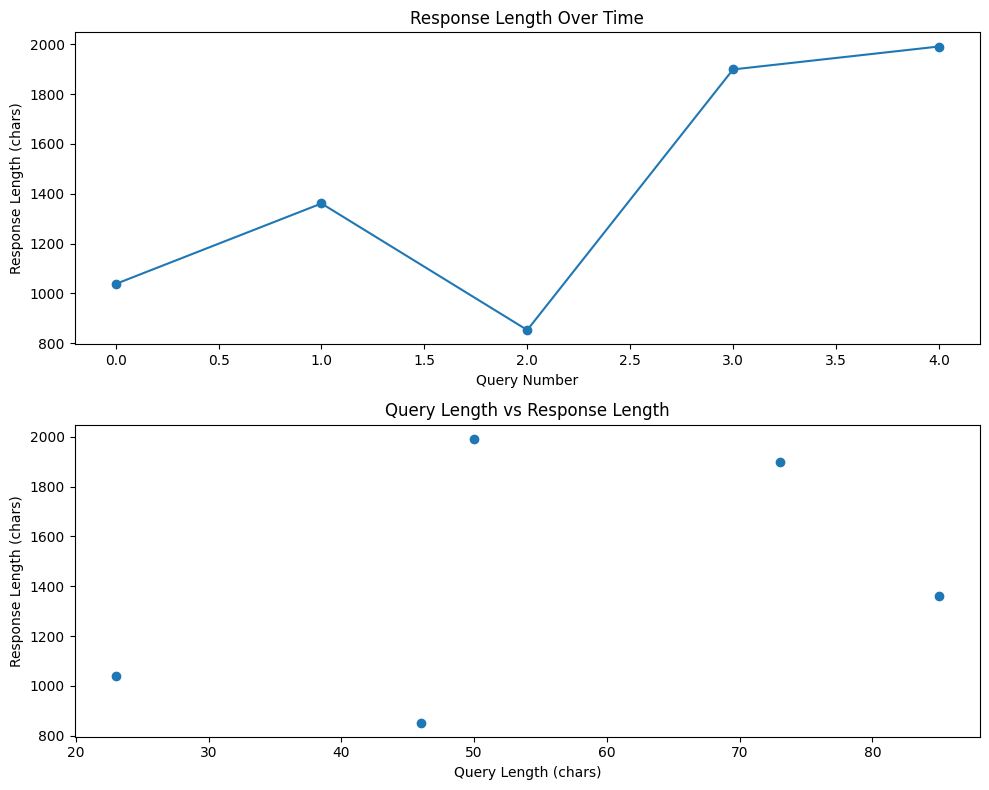

In [ ]:
analyzer = ChatbotAnalyzer(chatbot)
df = analyzer.analyze_conversations()
print(df.describe())